## **[2024년 1학기 로봇공학] Ch. 4-a. Import a Robot**

- 작성자 : 서울시립대학교 전자전기컴퓨터공학부 박경훈 교수(gyunghoon.park@uos.ac.kr)
- 작성일 : 2024. 3. 26.

In [44]:
import spatialgeometry as sg
import spatialmath as sm
import roboticstoolbox as rtb
import numpy as np
from spatialmath.base import *
from math import *
from scipy import *
from roboticstoolbox.backends import swift
import matplotlib.animation as animation
import matplotlib.pyplot as plt


이번 파일에서는 Robotics Toolbox for Python에서 제공하는 로봇 모델의 표현법들과, 저장된 로봇을 불러오는 방법에 대해 익혀보겠습니다.\
Robotics Toolbox for Python에서는 크게 다음의 3가지 형태의 로봇 표현법을 제공합니다.
- **Elementary transformation sequence (ETS)** : ${\rm Rot}$, ${\rm Trans}$ 등 기본적인 homogeneous transformation들의 조합을 통해 로봇의 기구학적 특성을 표현합니다. 
- **Universal robot description format (URDF)** : 잘 알려진 로봇 기술 방식인 URDF 파일에 적힌 정보들을 바탕으로 로봇 모델을 표현합니다.
- **Devanit-Hartenberg (DH)** : 역시 잘 알려진 DH convention으로 작성된 로봇 모델을 불러옵니다.

설명의 편의를 위해, 이번 파일에서는 Franka Emika Panda 로봇을 불러오는 법을 다루겠습니다.

### **Topic 1 : ETS Model**

Robotics Toolbox에서 자체 제공하는 ETS model들은 다음과 같습니다.

In [3]:
rtb.models.list(type="ETS")

┌─────────────┬───────────────┬─────────────────────┬──────┬─────┬──────┬───────────┬──────────┬──────────┬──────────┐
│   class     │     name      │    manufacturer     │ type │ DoF │ dims │ structure │ dynamics │ geometry │ keywords │
├─────────────┼───────────────┼─────────────────────┼──────┼─────┼──────┼───────────┼──────────┼──────────┼──────────┤
│Panda        │ Panda         │ Franka Emika        │ ETS  │ 7   │ 3d   │ RRRRRRR   │          │          │          │
│Frankie      │ Frankie       │ Franka Emika, Omron │ ETS  │ 9   │ 3d   │ RPRRRRRRR │          │          │ mobile   │
│Puma560      │ Puma560       │ Unimation           │ ETS  │ 6   │ 3d   │ RRRRRR    │          │          │          │
│Planar_Y     │ Planar-Y      │                     │ ETS  │ 6   │ 3d   │ RRRRRR    │          │          │          │
│GenericSeven │ Generic Seven │ Jesse's Imagination │ ETS  │ 7   │ 3d   │ RRRRRRR   │          │          │          │
│XYPanda      │ XYPanda       │ Franka Emika    

이 중 저희는 table에서 가장 상단에 위치한 Panda를 불러오도록 하겠습니다.

In [4]:
pandaETS = rtb.models.ETS.Panda()
print(pandaETS)

ERobot: Panda (by Franka Emika), 7 joints (RRRRRRR)
┌─────┬───────┬───────┬────────┬─────────────────────────────────────────────┐
│link │ link  │ joint │ parent │             ETS: parent to link             │
├─────┼───────┼───────┼────────┼─────────────────────────────────────────────┤
│   0 │ link0 │     0 │ BASE   │ tz(0.333) ⊕ Rz(q0)                          │
│   1 │ link1 │     1 │ link0  │ Rx(-90°) ⊕ Rz(q1)                           │
│   2 │ link2 │     2 │ link1  │ Rx(90°) ⊕ tz(0.316) ⊕ Rz(q2)                │
│   3 │ link3 │     3 │ link2  │ tx(0.0825) ⊕ Rx(90°) ⊕ Rz(q3)               │
│   4 │ link4 │     4 │ link3  │ tx(-0.0825) ⊕ Rx(-90°) ⊕ tz(0.384) ⊕ Rz(q4) │
│   5 │ link5 │     5 │ link4  │ Rx(90°) ⊕ Rz(q5)                            │
│   6 │ link6 │     6 │ link5  │ tx(0.088) ⊕ Rx(90°) ⊕ tz(0.107) ⊕ Rz(q6)    │
│   7 │ @ee   │       │ link6  │ tz(0.103) ⊕ Rz(-45°)                        │
└─────┴───────┴───────┴────────┴─────────────────────────────────────────────┘


첫 번째 table에서 *ETS: Parent to link*에 작성된 homogeneous transformation들은 현재의 parent link로부터 tree 구조 상 children에 해당하는 link의 특정 frame으로 이동하기 위해 필요한 rotation과 translation 정보를 담고 있습니다. 
- q0, $\cdots$, q6는 joint angle 값이며, robot model 입장에서는 변수로 취급합니다.
- $\oplus$는 두 homogeneous transformation의 곱 연산을 의미합니다. 
- tx($\cdot$)는 ${\rm Trans}(\hat{x},\cdot)$를, Rx($\cdot$)는 ${\rm Rot}(\hat{x},\cdot)$ 등을 의미합니다.
- qr, qz는 미리 설정된 configuration vector들이며, 아래 방식으로 출력이 가능합니다.

In [8]:
print(pandaETS.qr)

[ 0.         -0.3         0.         -2.2         0.          2.
  0.78539816]


또한 ERobot.plot() 함수를 이용하여 아래와 같이 그려볼 수 있습니다.

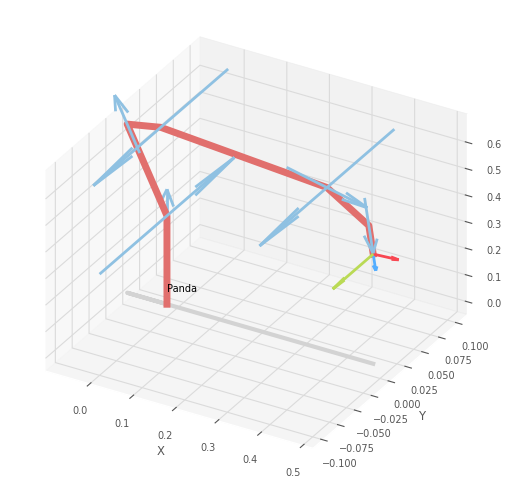

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Panda')

<Figure size 640x480 with 0 Axes>

In [11]:
pandaETS.plot(pandaETS.qr)

위의 pandaETS 모델은 pyplot을 이용하여 애니매이션할 수도 있습니다.\ 
[simPandaETS.py](simPandaETS.py) 파일을 구동해보세요.\
()

### **Topic 2 : URDF Model**

In [ ]:
rtb.models.list(type="URDF")

In [ ]:
pandaURDF = rtb.models.URDF.Panda()
pandaURDF.plot(pandaURDF.qr)

In [ ]:
print(pandaURDF)

In [ ]:
env = pandaURDF.plot(panda.qr, backend="swift");
from spatialgeometry import Cuboid
box = Cuboid([1, 1, 1], pose=sm.SE3.Tx(1.1));

env.add(box); # add box to graphics
env.step() # update the graphics

In [ ]:
# Make and instance of the Swift simulator and open it
env = swift.Swift()
env.launch(realtime=True)

# Set a desired and effector pose an an offset from the current end-effector pose
Tep = pandaURDF.fkine(panda.q) * sm.SE3.Tx(0.2) * sm.SE3.Ty(0.2) * sm.SE3.Tz(0.45)

# Add the robot to the simulator
env.add(pandaURDF)

# Simulate the robot while it has not arrived at the goal
arrived = False
while not arrived:
    # Work out the required end-effector velocity to go towards the goal
    v, arrived = rtb.p_servo(pandaURDF.fkine(pandaURDF.q), Tep, 1)
    
    # Set the Panda's joint velocities
    pandaURDF.qd = np.linalg.pinv(pandaURDF.jacobe(pandaURDF.q)) @ v
    
    # Step the simulator by 50 milliseconds
    env.step(0.001)

### **Topic 3 : DH Models**

In [17]:
rtb.models.list(type="DH")

┌─────────┬───────────────┬────────────────────┬──────┬─────┬──────┬────────────┬──────────┬──────────┬──────────────────────────┐
│ class   │     name      │    manufacturer    │ type │ DoF │ dims │  structure │ dynamics │ geometry │         keywords         │
├─────────┼───────────────┼────────────────────┼──────┼─────┼──────┼────────────┼──────────┼──────────┼──────────────────────────┤
│Panda    │ Panda         │ Franka Emika       │ DH   │ 7   │ 3d   │ RRRRRRR    │ Y        │ Y        │                          │
│Puma560  │ Puma 560      │ Unimation          │ DH   │ 6   │ 3d   │ RRRRRR     │ Y        │ Y        │ dynamics, symbolic, mesh │
│Stanford │ Stanford arm  │ Victor Scheinman   │ DH   │ 6   │ 3d   │ RRPRRR     │ Y        │          │ dynamics                 │
│Ball     │ ball          │                    │ DH   │ 10  │ 3d   │ RRRRRRRRRR │ Y        │          │                          │
│Hyper    │ Hyper10       │                    │ DH   │ 10  │ 3d   │ RRRRRRRRRR │ Y

In [21]:
Puma560 = rtb.models.DH.Puma560()
print(Puma560)

DHRobot: Puma 560 (by Unimation), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌────┬────────┬────────┬────────┬─────────┬────────┐
│θⱼ  │   dⱼ   │   aⱼ   │   ⍺ⱼ   │   q⁻    │   q⁺   │
├────┼────────┼────────┼────────┼─────────┼────────┤
│ q1 │ 0.6718 │      0 │  90.0° │ -160.0° │ 160.0° │
│ q2 │      0 │ 0.4318 │   0.0° │ -110.0° │ 110.0° │
│ q3 │   0.15 │ 0.0203 │ -90.0° │ -135.0° │ 135.0° │
│ q4 │ 0.4318 │      0 │  90.0° │ -266.0° │ 266.0° │
│ q5 │      0 │      0 │ -90.0° │ -100.0° │ 100.0° │
│ q6 │      0 │      0 │   0.0° │ -266.0° │ 266.0° │
└────┴────────┴────────┴────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
└─────┴─────┴──────┴──

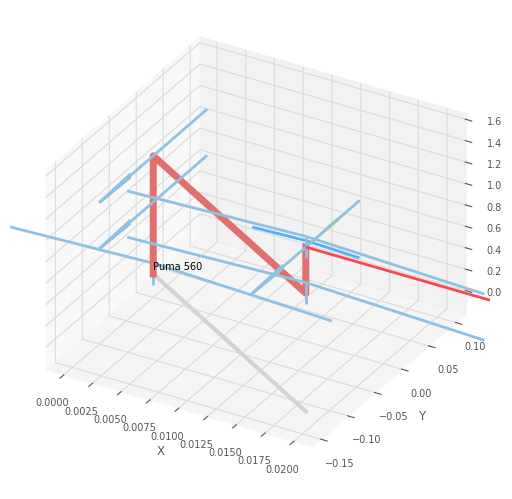

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Puma 560')

<Figure size 640x480 with 0 Axes>

In [22]:
Puma560.plot(Puma560.qr)

In [65]:
pyplot = rtb.backends.PyPlot()  # create a PyPlot backend
pyplot.add(pandaDH)              # add the robot to the backend
pandaDH.q = pandaDH.qz
pyplot.step()

TypeError: 'module' object is not callable